I'm converting the runner to a notebook so I can run it chunk by chunk and see the output:

# Imports

In [1]:
import math
import numpy as np
from scipy.io import loadmat
import torch
import gpytorch
from matplotlib import pyplot as plt
import dk_kernel

# Train and test data

In [2]:
train_x = torch.linspace(0, 1, 100)
test_x = torch.linspace(0.1, 1.1, 52)
train_y = torch.stack(
    [torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,], -1)

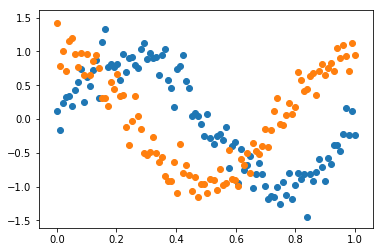

In [3]:
plt.scatter(train_x.numpy(),train_y[:,0].numpy())
plt.scatter(train_x.numpy(),train_y[:,1].numpy())
plt.show()

# Create kernel

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = dk_kernel.MultitaskRBFKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# Train hyperparameters

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 48.723
Iter 2/50 - Loss: 44.775
Iter 3/50 - Loss: 40.559
Iter 4/50 - Loss: 35.695
Iter 5/50 - Loss: 31.611
Iter 6/50 - Loss: 26.583
Iter 7/50 - Loss: 20.695


Iter 8/50 - Loss: 14.727
Iter 9/50 - Loss: 8.983
Iter 10/50 - Loss: 4.014
Iter 11/50 - Loss: -1.761
Iter 12/50 - Loss: -6.990
Iter 13/50 - Loss: -11.002
Iter 14/50 - Loss: -14.558


Iter 15/50 - Loss: -19.058
Iter 16/50 - Loss: -23.422
Iter 17/50 - Loss: -28.956
Iter 18/50 - Loss: -32.539
Iter 19/50 - Loss: -36.243
Iter 20/50 - Loss: -40.685


Iter 21/50 - Loss: -44.017
Iter 22/50 - Loss: -49.110
Iter 23/50 - Loss: -52.872
Iter 24/50 - Loss: -58.184
Iter 25/50 - Loss: -62.068
Iter 26/50 - Loss: -64.945


Iter 27/50 - Loss: -69.105
Iter 28/50 - Loss: -72.493
Iter 29/50 - Loss: -76.071
Iter 30/50 - Loss: -78.631
Iter 31/50 - Loss: -79.068
Iter 32/50 - Loss: -83.839
Iter 33/50 - Loss: -87.611


Iter 34/50 - Loss: -87.938
Iter 35/50 - Loss: -89.570
Iter 36/50 - Loss: -91.423
Iter 37/50 - Loss: -94.119
Iter 38/50 - Loss: -96.524
Iter 39/50 - Loss: -96.460


Iter 40/50 - Loss: -95.712
Iter 41/50 - Loss: -99.313
Iter 42/50 - Loss: -96.136
Iter 43/50 - Loss: -97.710
Iter 44/50 - Loss: -98.110
Iter 45/50 - Loss: -97.020
Iter 46/50 - Loss: -98.321


Iter 47/50 - Loss: -95.508
Iter 48/50 - Loss: -96.570
Iter 49/50 - Loss: -96.518
Iter 50/50 - Loss: -97.175


Make predictions

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Plot means and training data

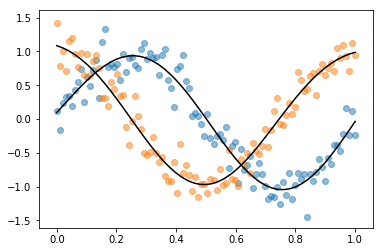

In [7]:
# training data and posterior mean from task 0
plt.scatter(train_x.detach().numpy(), train_y[:, 0].detach().numpy(),color='C0',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 0].numpy(), 'black')
# training data and posterior mean from task 1
plt.scatter(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), color='C1',alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 1].numpy(), 'black')


# Plot means and confidence region


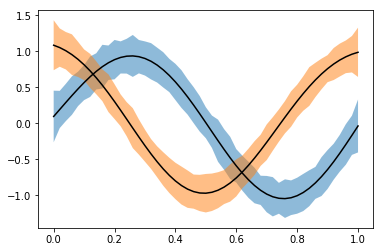

In [8]:
# training data and posterior mean from task 0
plt.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 0].numpy(), 'black')
# training data and posterior mean from task 1
plt.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
plt.plot(test_x.numpy(), mean[:, 1].numpy(), 'black')
